In [3]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

# Cat & Dog Classification with Tensorflow

In [4]:
# Import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
import os  
import cv2
import datetime
import IPython.display as display
import random
import h5py

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Activation

Using TensorFlow backend.


In [5]:
# Path to train & test data
!pwd
train_dir = './data/train/'
test_dir = './data/test1/'

/home/jupyter/simple_flask


## Prepare Traning Data

In [6]:
filenames = os.listdir(train_dir)
filenames[:10]

['cat.7693.jpg',
 'cat.3394.jpg',
 'cat.8963.jpg',
 'dog.8731.jpg',
 'dog.6752.jpg',
 'cat.6681.jpg',
 'dog.6601.jpg',
 'dog.4193.jpg',
 'dog.906.jpg',
 'cat.1966.jpg']

In [7]:
train_data = pd.DataFrame(filenames)
train_data.columns = ['filenames']
train_data['label'] = train_data.filenames.map(lambda x: x.split('.')[0])
train_data.head()

,filenames,label
0,cat.7693.jpg,cat
1,cat.3394.jpg,cat
2,cat.8963.jpg,cat
3,dog.8731.jpg,dog
4,dog.6752.jpg,dog


See value for each class

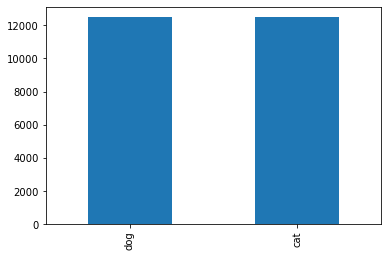

In [8]:
train_data.label.value_counts().plot.bar()

Load some sample image

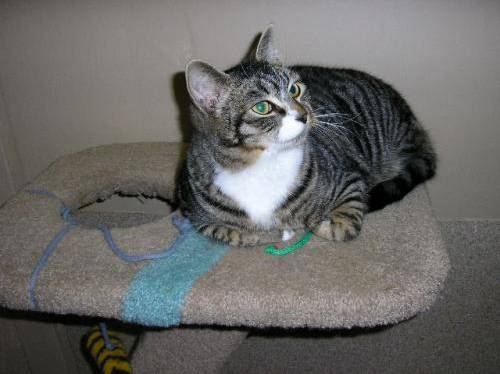

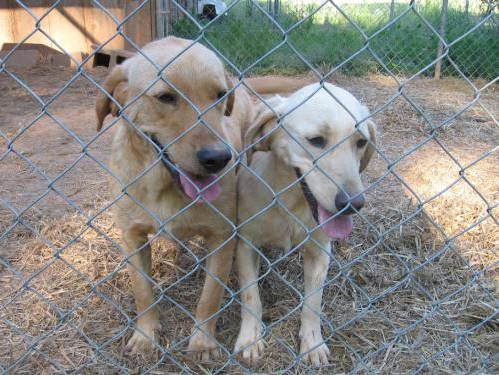

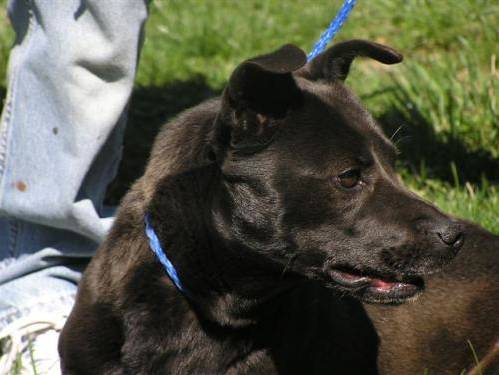

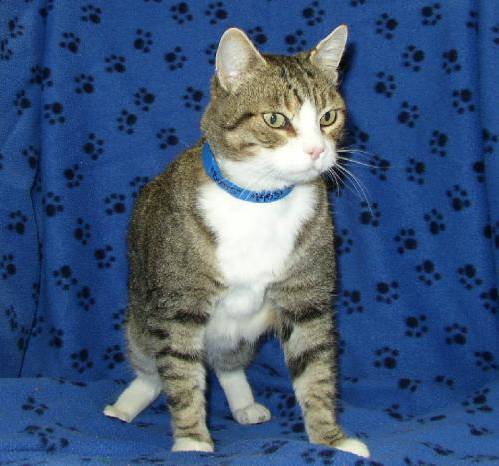

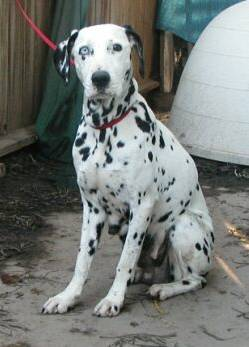

In [9]:
# Load some sample image
for _ in range(5):
    image_path = random.choice(train_data.filenames)
    display.display(display.Image(train_dir + image_path))
    print()

## To train a model with this dataset, you will want the data:

- To be well shuffeled
- To be batched
- To repeat forever
- Batches to be available as soon as possible

Shuffle order of training data

In [10]:
train_data = train_data.sample(frac = 1).reset_index(drop = True)
train_data.head(), train_data.tail()

(      filenames label
 0  dog.4545.jpg   dog
 1  dog.5797.jpg   dog
 2  dog.4350.jpg   dog
 3  cat.2566.jpg   cat
 4  dog.2369.jpg   dog,
            filenames label
 24995   dog.9666.jpg   dog
 24996   cat.6277.jpg   cat
 24997   dog.8013.jpg   dog
 24998   dog.1822.jpg   dog
 24999  cat.10153.jpg   cat)

Split data to train set and validation set

In [11]:
train_dataset, val_dataset = train_test_split(train_data, test_size=0.20, random_state=123)
train_dataset = train_dataset.reset_index(drop=True)
val_dataset = val_dataset.reset_index(drop=True)

Check class distribution in each set

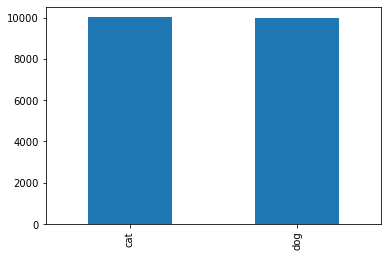

In [12]:
train_dataset.label.value_counts().plot.bar()

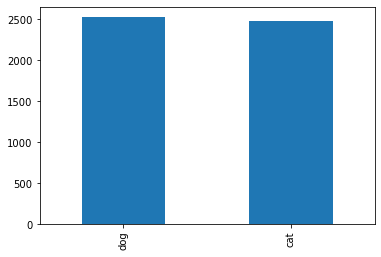

In [13]:
val_dataset.label.value_counts().plot.bar()

Dataset Generator

In [14]:
total_train = train_dataset.shape[0]
total_validate = val_dataset.shape[0]
BATCH_SIZE = 128
total_train, total_validate

(20000, 5000)

Train Generator

In [15]:
train_datagen = ImageDataGenerator(
    rotation_range = 30,
    rescale = 1./225,
    brightness_range = (0.7, 1.3),
    shear_range = 0.2,
    zoom_range = 0.3,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    fill_mode = 'nearest'
)

In [16]:
train_generator = train_datagen.flow_from_dataframe(
    train_dataset,
    directory = train_dir,
    x_col = 'filenames',
    y_col = 'label',
    target_size = (299, 299),
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


Validation Generator

In [17]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    val_dataset, 
    train_dir, 
    x_col = 'filenames',
    y_col = 'label',
    target_size = (299, 299),
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


### Test data generator

In [18]:
example = train_dataset.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example, 
    train_dir, 
    x_col = 'filenames',
    y_col = 'label',
    target_size = (299, 299),
    class_mode = 'categorical'
)

Found 1 validated image filenames belonging to 1 classes.


In [19]:
for X_batch, Y_batch in example_generator:
    image = X_batch[0]
    print(image.shape)
    break

(299, 299, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


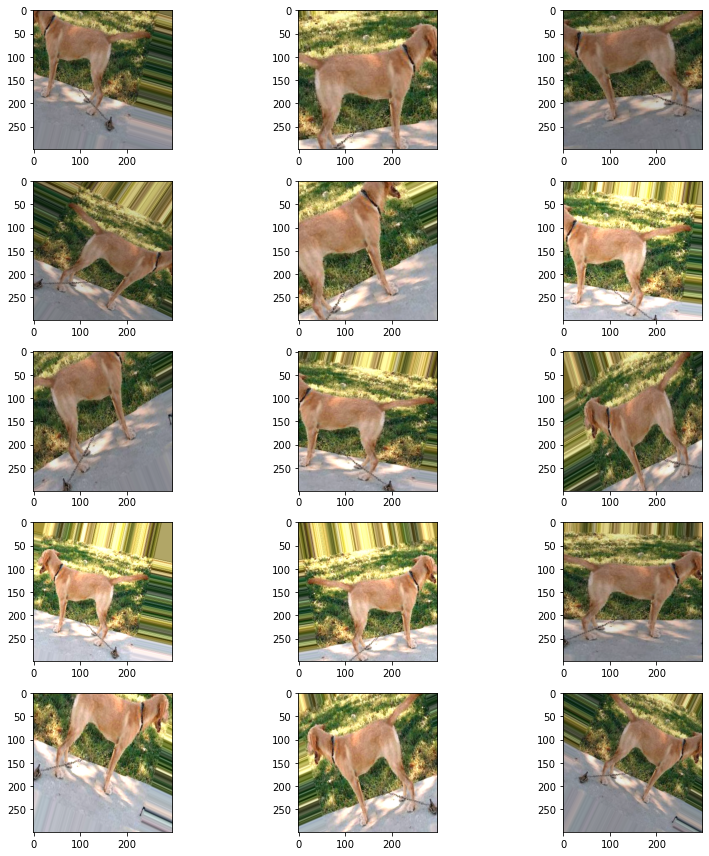

In [20]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# Building model


#### Setup Callbacks for model

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [19]:
earlystop = EarlyStopping(patience=5)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
callbacks = [earlystop, learning_rate_reduction]

In [22]:
# Visualize model history
def plot_history(history, key='loss'):
    plt.figure(figsize=(12,8))

    val = plt.plot(history.epoch, history.history['val_'+key],
                    '--', label=key.title() +' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                label=key.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

#### Using transfer learning with Keras Xception Application

In [62]:
# Define model
def define_model():
    # load model
    model = tf.keras.applications.Xception(include_top=False, input_shape=(299, 299, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    dropout = Dropout(0.2)(class1)
    output = Dense(2, activation='sigmoid')(dropout)
    # define new model
    model = tf.keras.Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = tf.keras.optimizers.RMSprop(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

md_xception2 = define_model()

In [23]:
# Train model
now = datetime.datetime.now
t = now()
# with tf.device('/device:GPU:0'):
#     model_history = md_xception2.fit(
#         train_generator,
#         epochs = 20,
#         validation_data = validation_generator,
#         validation_steps = total_validate // BATCH_SIZE,
#         steps_per_epoch = total_train // BATCH_SIZE,
#         callbacks = callbacks
#         )
model_history = md_xception2.fit(
        train_generator,
        epochs = 20,
        validation_data = validation_generator,
        validation_steps = total_validate // BATCH_SIZE,
        steps_per_epoch = total_train // BATCH_SIZE,
        callbacks = callbacks
        )

print('Training time: %ss' % (now() - t))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 645 steps, validate for 161 steps
Epoch 1/20
645/645 [==============================] - 804s 1s/step - loss: 0.7723 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/20
645/645 [==============================] - 486s 754ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
645/645 [==============================] - 484s 751ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/20
645/645 [==============================] - 480s 744ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
645/645 [==============================] - 478s 741ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
645/645 [==============================] - 482s 747ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Training time: 0:53:36.374757s


In [47]:
# Train model with 5000 sample
now = datetime.datetime.now
t = now()
# with tf.device('/device:GPU:0'):
#     model_history = md_xception2.fit(
#         train_generator,
#         epochs = 20,
#         validation_data = validation_generator,
#         validation_steps = total_validate // BATCH_SIZE,
#         steps_per_epoch = total_train // BATCH_SIZE,
#         callbacks = callbacks
#         )
model_history = md_xception2.fit(
        train_generator,
        epochs = 20,
        validation_data = validation_generator,
        validation_steps = total_validate // BATCH_SIZE,
        steps_per_epoch = total_train // BATCH_SIZE,
        callbacks = callbacks
        )

print('Training time: %ss' % (now() - t))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 31 steps, validate for 7 steps
Epoch 1/20
31/31 [==============================] - 98s 3s/step - loss: 3.9971 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
30/31 [============================>.] - ETA: 2s - loss: 0.6932 - accuracy: 0.5000
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 [==============================] - 94s 3s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/20
30/31 [============================>.] - ETA: 2s - loss: 0.6932 - accuracy: 0.5000
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
31/31 [==============================] - 97s 3s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
30/31 [============================>.] - ETA: 2s - loss: 0.6932 - accuracy: 0.5000
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250000

KeyboardInterrupt: 

In [49]:
# Train model with 5000 sample
# Edit number of nodes in output layer from 1 to 2
now = datetime.datetime.now
t = now()

model_history = md_xception2.fit(
        train_generator,
        epochs = 20,
        validation_data = validation_generator,
        validation_steps = total_validate // BATCH_SIZE,
        steps_per_epoch = total_train // BATCH_SIZE,
        callbacks = callbacks
        )

print('Training time: %ss' % (now() - t))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 31 steps, validate for 7 steps
Epoch 1/20
31/31 [==============================] - 96s 3s/step - loss: 1.2318 - accuracy: 0.9095 - val_loss: 0.1241 - val_accuracy: 0.9821
Epoch 2/20
30/31 [============================>.] - ETA: 2s - loss: 0.1128 - accuracy: 0.9669
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 [==============================] - 95s 3s/step - loss: 0.1144 - accuracy: 0.9666 - val_loss: 0.1607 - val_accuracy: 0.9621
Epoch 3/20
30/31 [============================>.] - ETA: 2s - loss: 0.0727 - accuracy: 0.9694
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
31/31 [==============================] - 94s 3s/step - loss: 0.0728 - accuracy: 0.9694 - val_loss: 0.1388 - val_accuracy: 0.9648
Epoch 4/20
30/31 [============================>.] - ETA: 2s - loss: 0.0720 - accuracy: 0.9701
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250000

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 31 steps, validate for 7 steps
Epoch 1/20
31/31 [==============================] - 162s 5s/step - loss: 1.9145 - accuracy: 0.8942 - val_loss: 0.0481 - val_accuracy: 0.9827
Epoch 2/20
30/31 [============================>.] - ETA: 3s - loss: 0.1046 - accuracy: 0.9697
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 [==============================] - 101s 3s/step - loss: 0.1042 - accuracy: 0.9699 - val_loss: 0.0534 - val_accuracy: 0.9749
Epoch 3/20
30/31 [============================>.] - ETA: 3s - loss: 0.0899 - accuracy: 0.9757
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
31/31 [==============================] - 101s 3s/step - loss: 0.0902 - accuracy: 0.9760 - val_loss: 0.0632 - val_accuracy: 0.9710
Epoch 4/20
30/31 [============================>.] - ETA: 3s - loss: 0.0840 - accuracy: 0.9721
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250

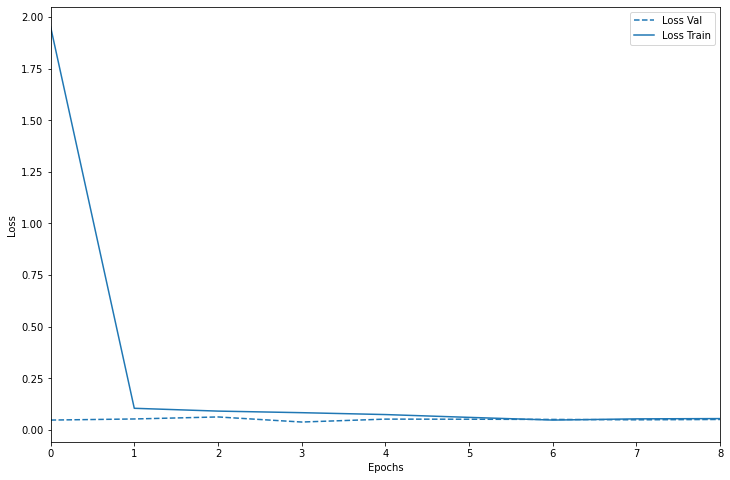

In [26]:
# Train model with 5000 sample
# Edit number of nodes in output layer from 1 to 2
now = datetime.datetime.now
t = now()

model_history = md_xception2.fit(
        train_generator,
        epochs = 20,
        validation_data = validation_generator,
        validation_steps = total_validate // BATCH_SIZE,
        steps_per_epoch = total_train // BATCH_SIZE,
        callbacks = callbacks
        )

print('Training time: %ss' % (now() - t))

plot_history(model_history, key = 'loss')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 156 steps, validate for 39 steps
Epoch 1/50
156/156 [==============================] - 453s 3s/step - loss: 2.8341 - accuracy: 0.9560 - val_loss: 0.0817 - val_accuracy: 0.9822
Epoch 2/50
156/156 [==============================] - 466s 3s/step - loss: 0.0992 - accuracy: 0.9614 - val_loss: 0.0958 - val_accuracy: 0.9840
Epoch 3/50
156/156 [==============================] - 477s 3s/step - loss: 0.0957 - accuracy: 0.9639 - val_loss: 0.1017 - val_accuracy: 0.9814
Epoch 4/50
156/156 [==============================] - 457s 3s/step - loss: 0.0868 - accuracy: 0.9692 - val_loss: 0.1005 - val_accuracy: 0.9815
Epoch 5/50
155/156 [============================>.] - ETA: 2s - loss: 0.0913 - accuracy: 0.9698
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
156/156 [==============================] - 451s 3s/step - loss: 0.0919 - accuracy: 0.9699 - val_loss: 0.0905 - val_accuracy: 0.9752
Epoch 6/50
156/156 [=======

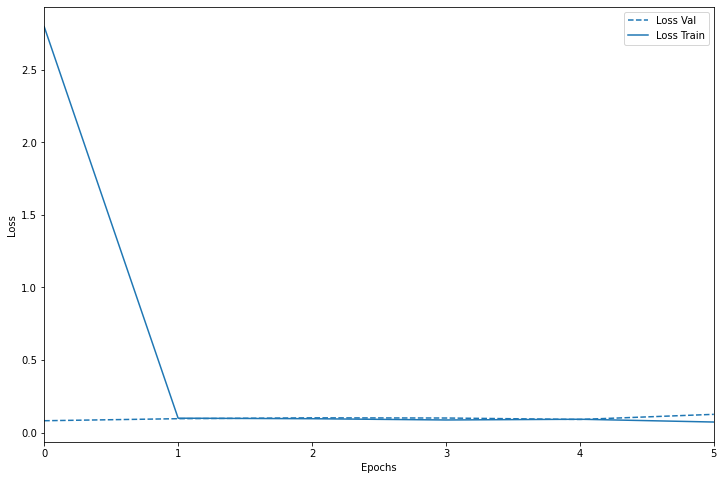

In [63]:
# Train model with train-val by 8:2 ration, EarlyStopping 5, ReduceLR 3
now = datetime.datetime.now
t = now()

model_history = md_xception2.fit(
        train_generator,
        epochs = 50,
        validation_data = validation_generator,
        validation_steps = total_validate // BATCH_SIZE,
        steps_per_epoch = total_train // BATCH_SIZE,
        callbacks = callbacks
        )

print('Training time: %ss' % (now() - t))

plot_history(model_history, key = 'loss')

In [64]:
# Save model
md_xception2.save('catdog_xception_rmsdrop_imggen.h5')

In [22]:
# Load model
STATIC_FOLDER = 'static'
model = tf.keras.models.load_model(STATIC_FOLDER + '/' + 'catdog_xception_rmsdrop_imggen.h5')

In [23]:
testfiles = os.listdir(test_dir)
testfiles[:10]

['7100.jpg',
 '2924.jpg',
 '2307.jpg',
 '5552.jpg',
 '9563.jpg',
 '4271.jpg',
 '7417.jpg',
 '3840.jpg',
 '4516.jpg',
 '2839.jpg']

In [24]:
test_df = pd.DataFrame(testfiles)
test_df.columns = ['filename']
test_df

,filename
0,7100.jpg
1,2924.jpg
2,2307.jpg
3,5552.jpg
4,9563.jpg
...,...
10239,4764.jpg
10240,953.jpg
10241,3012.jpg
10242,7365.jpg


In [97]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df.sample(10),
    directory = test_dir,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 10 validated image filenames.


In [67]:
# Preprocess an image
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [299, 299])
    image /= 255.0  # normalize to [0,1] range

    return image

# Read the image from path and preprocess
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

# Predict & classify image
def classify(model, image_path):
    print(image_path)
    preprocessed_imgage = load_and_preprocess_image(image_path)
    preprocessed_imgage = tf.reshape(preprocessed_imgage, (1, 299, 299, 3))

    prob = model.predict(preprocessed_imgage)
    print(prob)
    label = "Cat" if prob[0][0] > prob[0][1] else "Dog"
    classified_prob = prob[0][0] if prob[0][0] > prob[0][1] else prob[0][1]
    
    return label, classified_prob

./data/test1/3288.jpg
[[2.6873865e-34 1.0000000e+00]]
('Dog', 1.0)


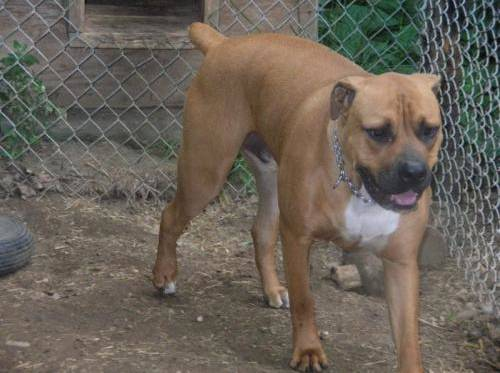

In [92]:
tests = test_dir + np.random.choice(testfiles)
print(classify(model, tests))
display.display(display.Image(tests))

In [98]:
# Predict from generator (returns probabilities)
pred = model.predict(test_generator,  steps=np.ceil(test_df.shape[0]/32), verbose=1)

  1/321 [..............................] - ETA: 1:24WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 321.0 batches). You may need to use the repeat() function when building your dataset.


In [99]:
cate = np.argmax(pred, axis=-1)

In [105]:
cate, pred

(array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1]),
 array([[1.8843914e-06, 9.9999702e-01],
        [4.9208108e-34, 1.0000000e+00],
        [1.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 0.0000000e+00],
        [7.2864731e-29, 1.0000000e+00],
        [1.0000000e+00, 0.0000000e+00],
        [1.0000000e+00, 4.5747731e-38],
        [2.3464917e-21, 1.0000000e+00]], dtype=float32))